In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#### Reading the dataset

In [3]:
df = pd.read_csv('Click Counts.txt', delim_whitespace=True)
df.head()

,Date,Click,Count
0,01/01/16,0:00,2093576
1,02/01/16,0:00,2397260
2,03/01/16,0:00,2173039
3,04/01/16,0:00,2051240
4,05/01/16,0:00,1954117


In [4]:
# Make a copy of the original DataFrame 'df' and store it in 'modified_df'
modified_df = df.copy()

# Rename the 'Count' column to 'Click counts' in the 'modified_df' DataFrame
modified_df.rename(columns={'Count': 'Click counts'}, inplace=True)

# Drop the 'Click' column from the 'modified_df' DataFrame
modified_df.drop(columns=['Click'], inplace=True)

#### Exploratory Data Analysis

##### Understanding the data

In [5]:
print(modified_df.shape)

modified_df.info()

(1285, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          1285 non-null   object
 1   Click counts  1285 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.2+ KB


**Insights**

1. The DataFrame has a shape of (1285, 3), indicating that it contains 1285 rows and 3 columns, suggesting a relatively large dataset with 1285 data points.

2. The DataFrame consists of three columns: 'Click counts,' 'Year,' and 'Month,' all of which have non-null values for all 1285 entries and are of integer data type (int64). This suggests that the dataset is complete, with no missing values in these columns, and the data types are appropriate for the analysis.

In [6]:
pd.set_option('display.float_format', '{:,.2f}'.format)
print(modified_df.describe())

       Click counts
count      1,285.00
mean   2,231,746.63
std    1,245,358.43
min    1,061,345.00
25%    1,652,568.00
50%    1,980,385.00
75%    2,360,693.00
max   13,714,689.00


**Insights**

The "Click counts" data reveals a positively skewed distribution with a mean of 2.2 million clicks, but significant variability, as evidenced by the standard deviation of approximately 1.2 million clicks. Additionally, there are potential outliers, as the maximum value of 13.7 million clicks significantly exceeds the upper quartile.

##### Checking & Handling the Missing Value

In [7]:
print(modified_df.isnull().sum())

Date            0
Click counts    0
dtype: int64


##### Feature Engineering

In [8]:
# Convert 'Date' column to datetime data type with dayfirst=True to handle date formats where the day appears first
modified_df['Date'] = pd.to_datetime(modified_df['Date'], dayfirst=True)

# Extract and add a new column for the year from the 'Date' column
modified_df['Year'] = modified_df['Date'].dt.year

# Extract and add a new column for the month from the 'Date' column
modified_df['Month'] = modified_df['Date'].dt.month

# Extract and add a new column for the day from the 'Date' column
modified_df['Day'] = modified_df['Date'].dt.day

# Extract and add a new column for the day of the week (0 = Monday, 6 = Sunday) from the 'Date' column
modified_df['DayofWeek'] = modified_df['Date'].dt.dayofweek


##### Decompose the Time Series

<Figure size 1000x600 with 0 Axes>

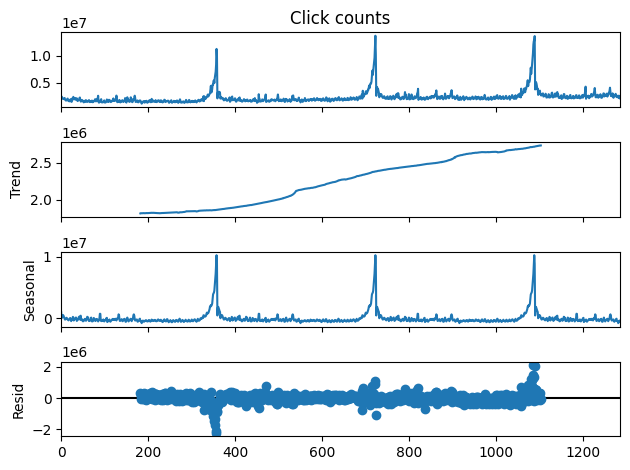

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Create a larger figure
plt.figure(figsize=(10, 6))

# Perform seasonal decomposition
result = seasonal_decompose(modified_df['Click counts'], model='additive', period=365)

# Plot the decomposition
result.plot()

# Show the plot
plt.show()


##### Check for Stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(modified_df['Click counts'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -5.502093514923181
p-value: 2.06036331485879e-06


**Null Hypothesis (H0):** The time series data has a unit root, indicating it is non-stationary.

**Alternative Hypothesis (H1):** The time series data does not have a unit root, indicating it is stationary.

**Inference:** The ADF Statistic of approximately -5.50 and a very low p-value (2.06e-06) suggest that we reject the null hypothesis. This implies that the time series data is likely stationary, as it does not possess a unit root. Stationary data is often easier to model and analyze for time series forecasting.


##### Lag Feature for Stationary

In [11]:
modified_df['Lag_December'] = modified_df['Click counts'].shift(365)

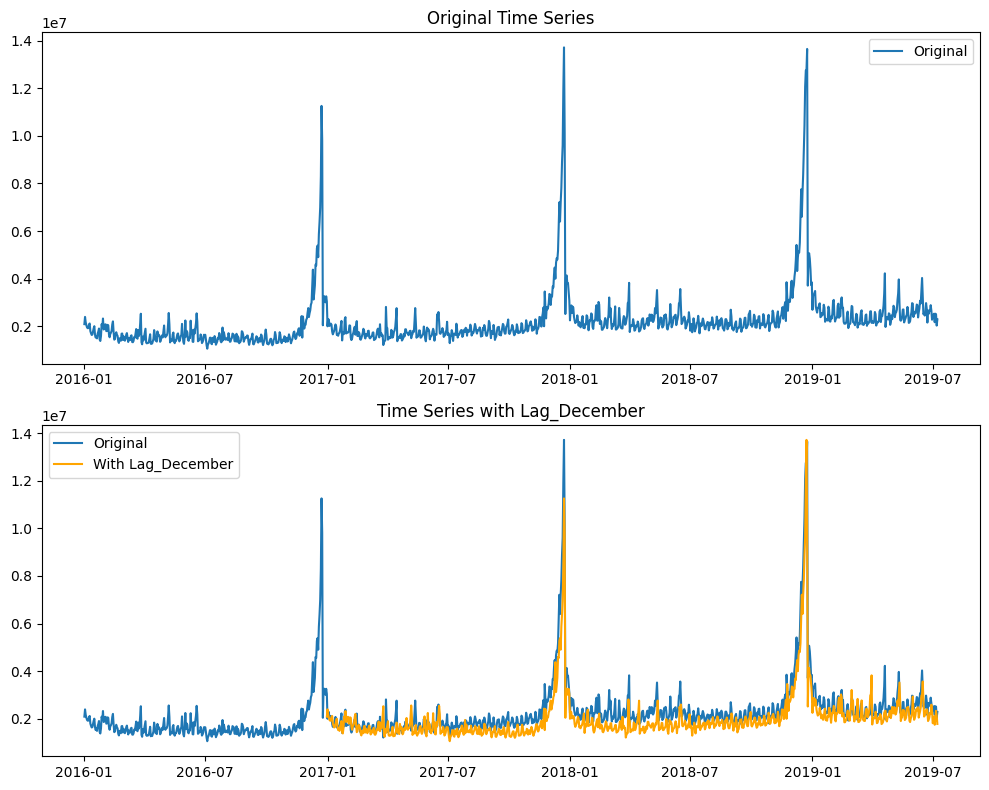

In [12]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the original time series
ax1.plot(modified_df['Date'], modified_df['Click counts'], label='Original')
ax1.set_title('Original Time Series')
ax1.legend()

# Plot the time series with the 'Lag_December' column
ax2.plot(modified_df['Date'], modified_df['Click counts'], label='Original')
ax2.plot(modified_df['Date'], modified_df['Lag_December'], label='With Lag_December', color='orange')
ax2.set_title('Time Series with Lag_December')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [13]:
modified_df['Rolling_Mean'] = modified_df['Click counts'].rolling(window=30).mean()
modified_df['Rolling_STD'] = modified_df['Click counts'].rolling(window=30).std()

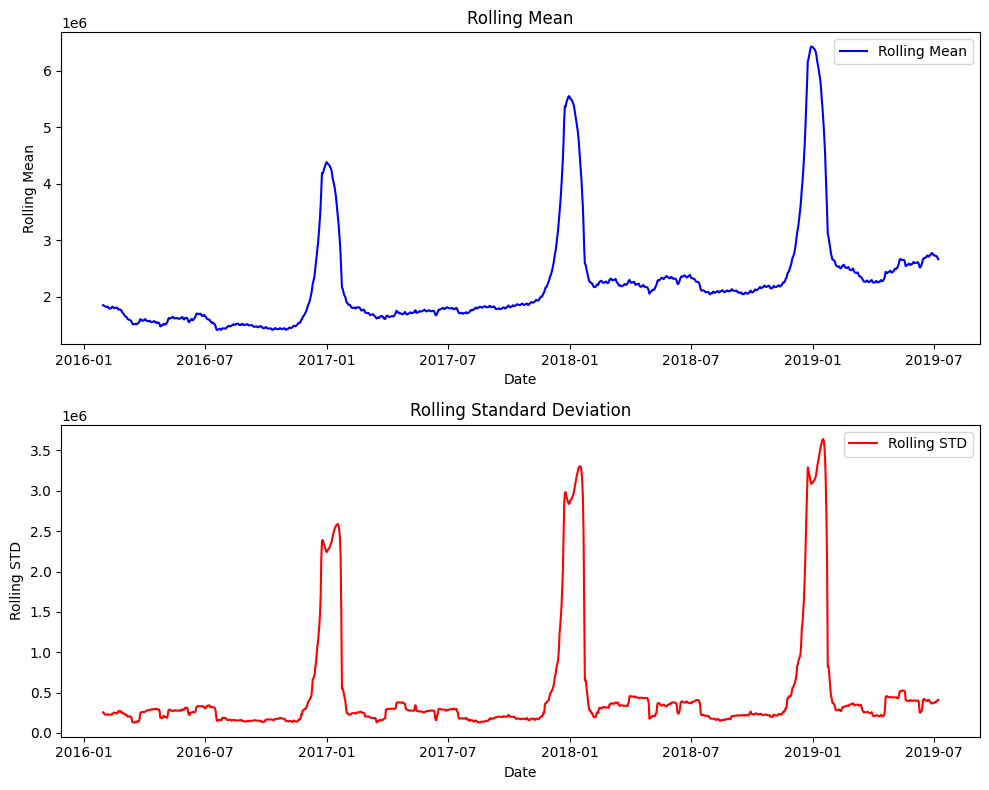

In [14]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the rolling mean in the first subplot
ax1.plot(modified_df['Date'], modified_df['Rolling_Mean'], label='Rolling Mean', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Mean')
ax1.set_title('Rolling Mean')
ax1.legend()

# Plot the rolling standard deviation in the second subplot
ax2.plot(modified_df['Date'], modified_df['Rolling_STD'], label='Rolling STD', color='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Rolling STD')
ax2.set_title('Rolling Standard Deviation')
ax2.legend()

# Adjust layout for better visualization
plt.tight_layout()

# Display the subplots
plt.show()


##### Data Visualization

<Figure size 1000x600 with 0 Axes>

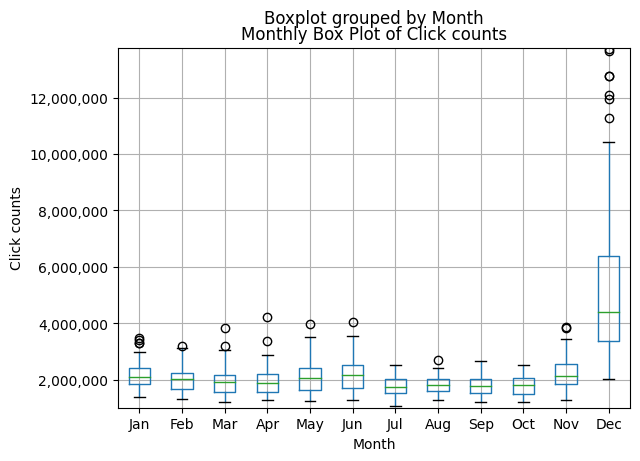

In [15]:
plt.figure(figsize=(10, 6))
modified_df.boxplot(column='Click counts', by='Month')
plt.title('Monthly Box Plot of Click counts')
plt.xlabel('Month')
plt.ylabel('Click counts')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Define a custom tick formatter to display y-axis values in absolute number format
def format_y_ticks(value, _):
    return f'{int(value):,}'  # Format as comma-separated integers

plt.gca().get_yaxis().set_major_formatter(FuncFormatter(format_y_ticks))

# Set custom y-axis limits to cover the range of your data
plt.ylim(min(modified_df['Click counts']) - 50000, max(modified_df['Click counts']) + 50000)

# Set the aspect ratio to 'auto' to allow automatic adjustment of the figure size
plt.gca().set_aspect('auto')

plt.show()


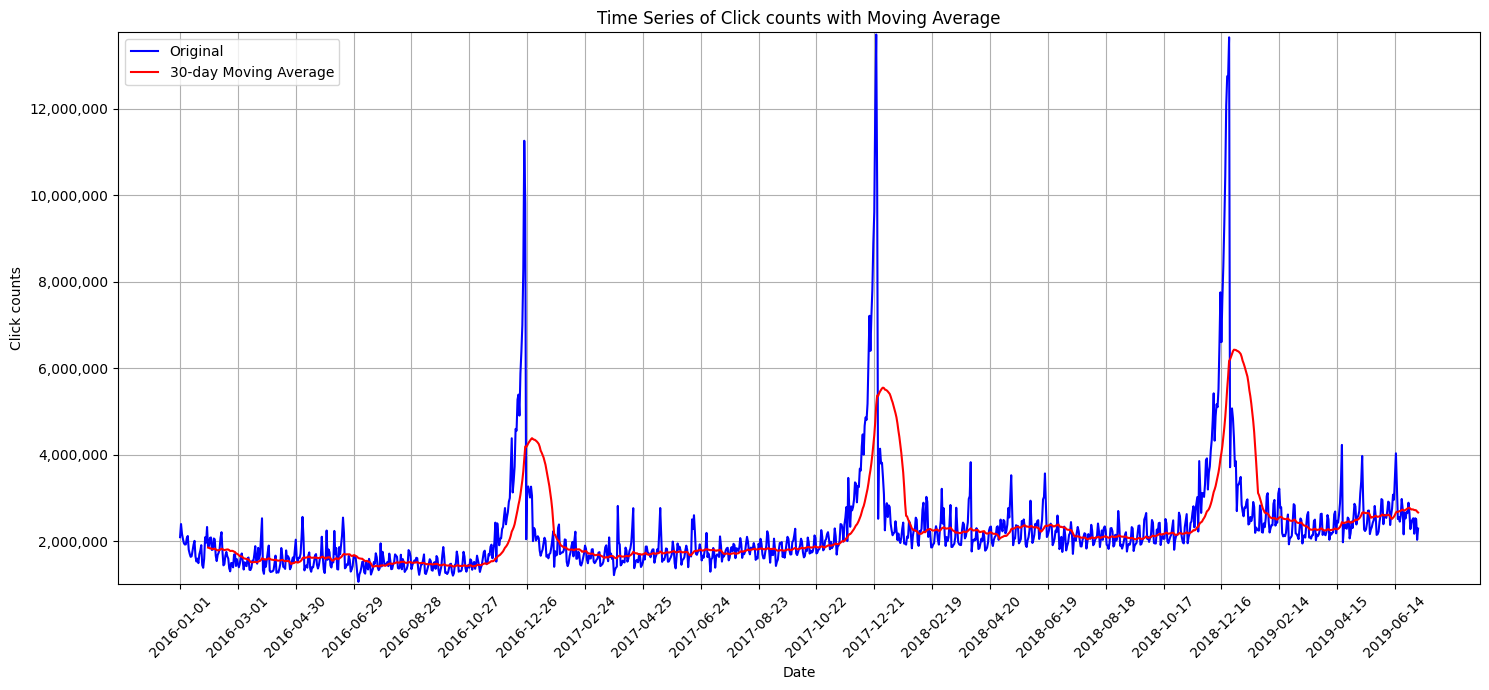

In [16]:
# Convert 'Date' to datetime if not already done
modified_df['Date'] = pd.to_datetime(modified_df['Date'], dayfirst=True)

# Compute the moving average
rolling_mean = modified_df['Click counts'].rolling(window=30).mean()

plt.figure(figsize=(15, 7))

# Plot original data and moving average
plt.plot(modified_df['Date'], modified_df['Click counts'], label='Original', color='blue')
plt.plot(modified_df['Date'], rolling_mean, label='30-day Moving Average', color='red')

# Adjusting the x-axis for better readability
plt.xticks(modified_df['Date'][::60], rotation=45)  # You can adjust the interval (here, 60 days) based on your preference

# Define a custom tick formatter to display y-axis values in absolute number format
def format_y_ticks(value, _):
    return f'{int(value):,}'  # Format as comma-separated integers

plt.gca().get_yaxis().set_major_formatter(FuncFormatter(format_y_ticks))

# Set custom y-axis limits to cover the range of your data
plt.ylim(min(modified_df['Click counts']) - 50000, max(modified_df['Click counts']) + 50000)

plt.title('Time Series of Click counts with Moving Average')
plt.xlabel('Date')
plt.ylabel('Click counts')
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()



**Insights**|
1. The data shows clear seasonal patterns, with a consistent increase in click counts during November and December. This likely reflects holiday shopping and end-of-year promotions, indicating a strong correlation with external factors like Black Friday and Christmas sales.
2. After the holiday season, click counts exhibit a steady decline, returning to baseline levels. This post-holiday drop suggests that the seasonal spikes are temporary and that sustained engagement strategies are needed to maintain user interest.



In [17]:
# Assuming modified_df is sorted by date
# Keeping the last year's data as the test set
train = modified_df[modified_df['Date'] < modified_df['Date'].iloc[-1] - pd.DateOffset(years=1)]
test = modified_df[modified_df['Date'] >= modified_df['Date'].iloc[-1] - pd.DateOffset(years=1)]


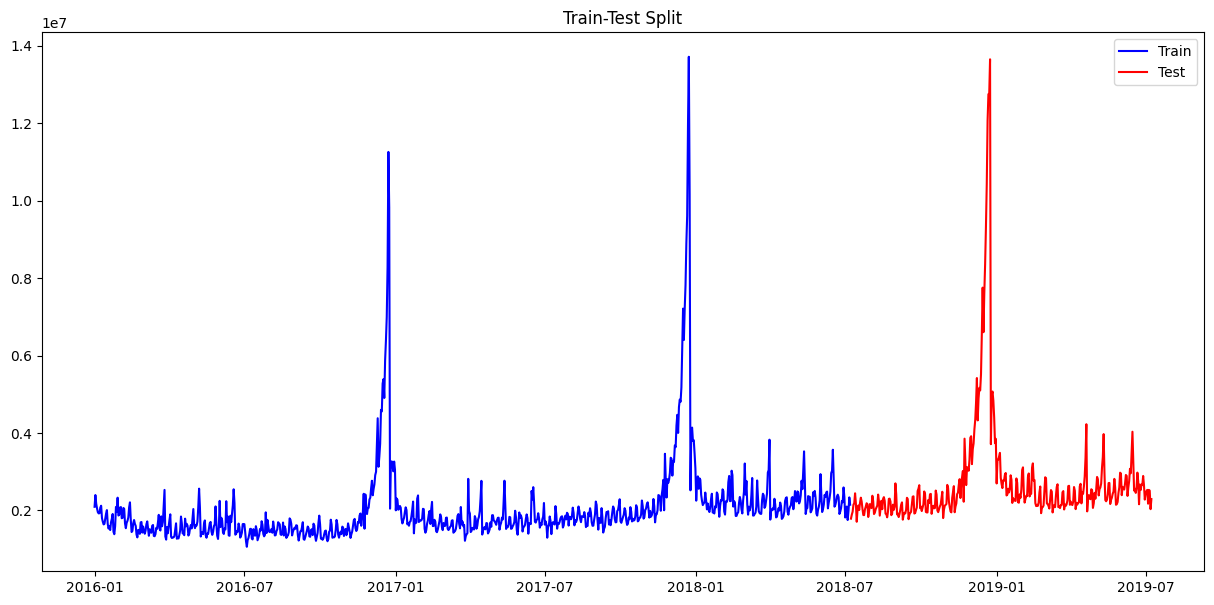

In [18]:
import matplotlib.pyplot as plt

# Visualizing the split
plt.figure(figsize=(15, 7))
plt.plot(train['Date'], train['Click counts'], label='Train', color='blue')
plt.plot(test['Date'], test['Click counts'], label='Test', color='red')
plt.legend(loc='best')
plt.title("Train-Test Split")
plt.show()


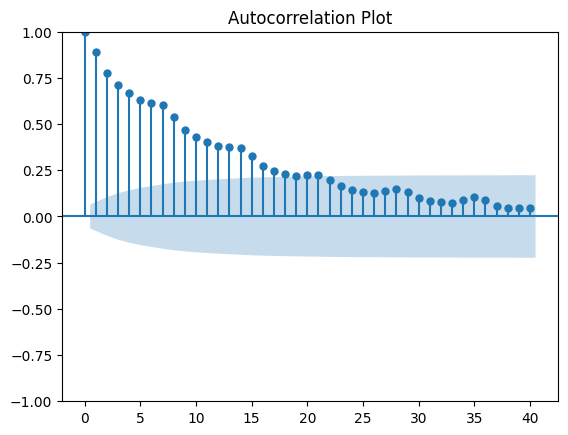

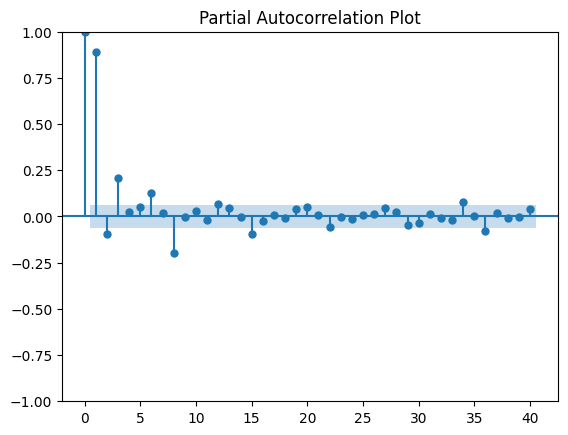

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure()
plot_acf(train['Click counts'], lags=40, ax=plt.gca())
plt.title('Autocorrelation Plot')
plt.figure()
plot_pacf(train['Click counts'], lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot')
plt.show()


In [31]:
from statsmodels.tsa.arima.model import ARIMA

# Example ARIMA order (you should select based on ACF and PACF plots and iteratively refine)
order = (2,2,15)  # This is just a placeholder, replace with the appropriate order

model = ARIMA(train['Click counts'], order=order)
model_fit = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


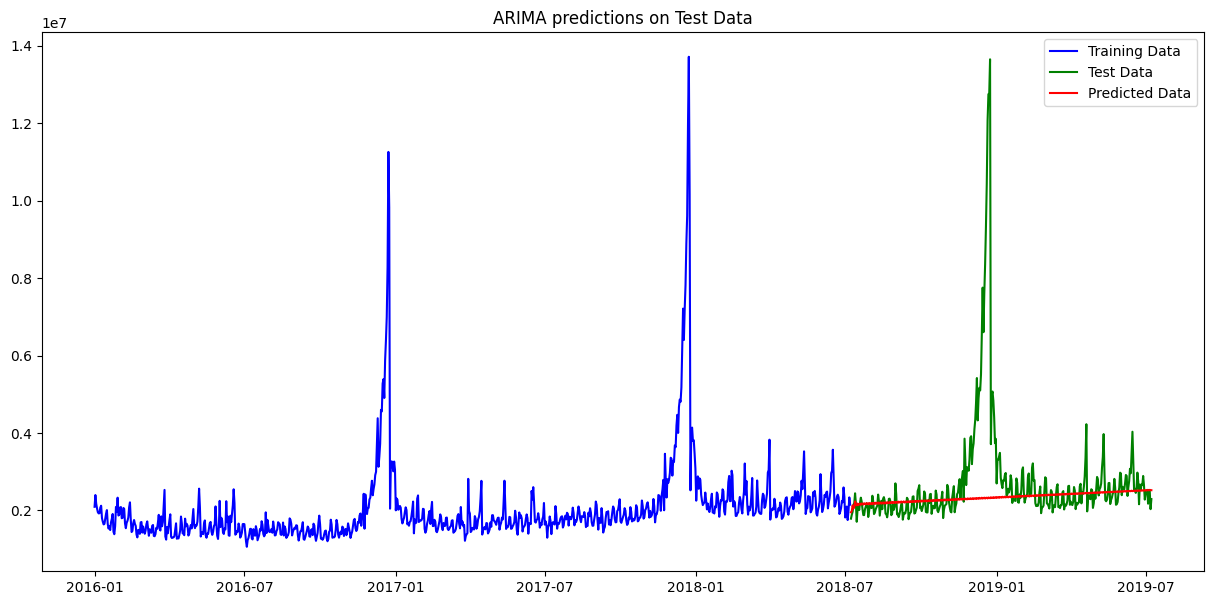

In [32]:
forecast = model_fit.forecast(steps=len(test))

plt.figure(figsize=(15,7))
plt.plot(train['Date'], train['Click counts'], 'blue', label='Training Data')
plt.plot(test['Date'], test['Click counts'], 'green', label='Test Data')
plt.plot(test['Date'], forecast, 'red', label='Predicted Data')
plt.legend()
plt.title('ARIMA predictions on Test Data')
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(test['Click counts'], forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Click counts'], forecast)
mape = np.mean(np.abs(test['Click counts'] - forecast)/np.abs(test['Click counts'])) * 100

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')


MSE: 2479556972338.889
RMSE: 1574660.907096791
MAE: 662745.2168299349
MAPE: 16.575289148556823%


In [ ]:
# Preparing data
prophet_df = modified_df.rename(columns={"Date": "ds", "Click counts": "y"})

In [ ]:
# !pip install pystan==2.19.1.1
# !pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 46.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np

# Scaling the dataset for neural network training
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train[['Click counts']])

# Create dataset with timesteps for LSTM
X_train = []
y_train = []

for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()

# Adding the first LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding the second LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Adding the third LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Adding the fourth LSTM layer with dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the LSTM model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
27/27 [==============================] - 18s 115ms/step - loss: 0.0074
Epoch 2/100
27/27 [==============================] - 4s 161ms/step - loss: 0.0061
Epoch 3/100
27/27 [==============================] - 3s 120ms/step - loss: 0.0058
Epoch 4/100
27/27 [==============================] - 3s 113ms/step - loss: 0.0054
Epoch 5/100
27/27 [==============================] - 3s 119ms/step - loss: 0.0044
Epoch 6/100
27/27 [==============================] - 4s 162ms/step - loss: 0.0041
Epoch 7/100
27/27 [==============================] - 3s 118ms/step - loss: 0.0042
Epoch 8/100
27/27 [==============================] - 3s 117ms/step - loss: 0.0035
Epoch 9/100
27/27 [==============================] - 3s 116ms/step - loss: 0.0039
Epoch 10/100
27/27 [==============================] - 4s 161ms/step - loss: 0.0030
Epoch 11/100
27/27 [==============================] - 3s 123ms/step - loss: 0.0037
Epoch 12/100
27/27 [==============================] - 4s 157ms/step - loss: 0.0034
Epoch 13/100

In [ ]:
total_data = pd.concat((train[['Click counts']], test[['Click counts']]), axis=0)
inputs = total_data[len(total_data) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, len(test)+60):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
predicted_click_counts = model.predict(X_test)
predicted_click_counts = scaler.inverse_transform(predicted_click_counts)


12/12 [==============================] - 4s 72ms/step


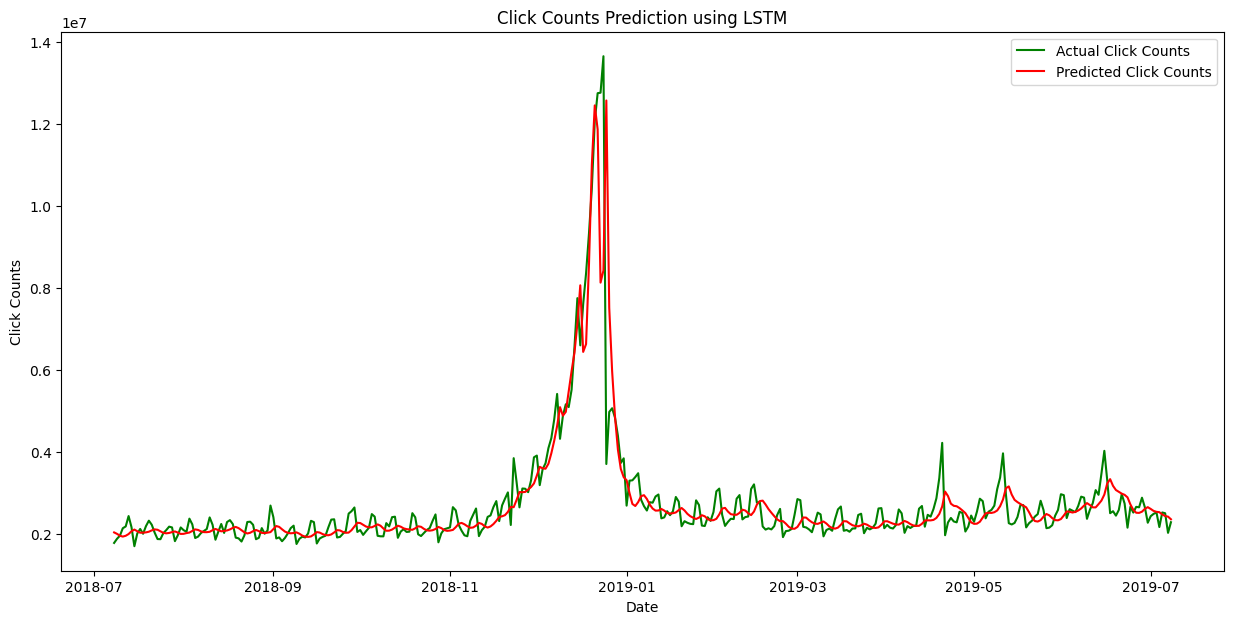

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(test['Date'], test['Click counts'], 'green', label='Actual Click Counts')
plt.plot(test['Date'], predicted_click_counts, 'red', label='Predicted Click Counts')
plt.title('Click Counts Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Click Counts')
plt.legend()
plt.show()
